Задача - спрогнозировать выручку на 12 месяцев вперед на основании данных о ежемесячных продажах за период с 2019 года по 2024 год.

Есть данные о продажах в рублях, продажах в штуках, наценке в % и стоимости курса доллара. Шаг временного периода - месяц.

Источник данных о курсе доллара https://ru.investing.com/currencies/usd-rub-historical-data

Особенности задачи:
- влияние внешних факторов на выручку - 2020 год и 2022 год -  резкий рост продаж из-за политических событий, такой аномальный уровень продаж не должен влиять на прогноз, данные необходимо корректно заменить, учитывая годовую сезонность продаж;
- курс долллара влияет на товарооборт в рублях, но самостоятельно прогнозировать его не можем - необходимо решить, включать его в модель или нет.



In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

#для работы с датами
import datetime as dt
from pandas. tseries.offsets import DateOffset

#графики
import matplotlib.pyplot as plt
import seaborn as sns

#Основаня модель
from prophet import Prophet

#Подбор гиперпараметров OPTUNA
import optuna
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#метрика для обучения модели
from sklearn.metrics import mean_absolute_error

#аномалии в сезонном режиме
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
#размер теста  в днях и название региона
test_size = 12
name = 'Москва'
business = 'Дистрибуция на коммерческом рынке'
#уровень классификации выбросов

contamination_price = 0.05
contamination_sales = 0.25
contamination_unit = 0.35

#количество сессий обучения модели
N_trials = 50

In [ ]:
dollar = pd.read_excel('КурсДоллара.xlsx', usecols = ['Дата','Цена'], parse_dates = ['Дата'])
dollar.columns = ['Месяц','Доллар']
dollar.head(2)

,Месяц,Доллар
0,2024-07-01,88.0079
1,2024-06-01,85.5332


Считываю данные о продажах, определяю границу тестового и тренингового периода для модели first_test_data

Также мне нужна отметка времени конца первого года данных min_level_data
Буду менять аномальные значения продаж на среднее между аналогичными месяцами соседних лет, а если аномалия нашлась в первом году данных, то на значение аналогичного месяца следующего года.

Привожу все числовые данные  - товарооборот, наценку, стоимость доллара к единому масштабу, чтобы уравнять их в значимости - это нужно для работы модели.

In [ ]:
df1 = pd.read_excel('СводРегионБизнес.xlsx',sheet_name = '2020_2021',parse_dates = ['Месяц'] )
df2 = pd.read_excel('СводРегионБизнес.xlsx',sheet_name = '2022_2024',parse_dates = ['Месяц'] )

df3 = pd.concat([df1,df2],ignore_index = True)
df3 = df3[(df3['Бизнес'] != '3PL')]

df4 = pd.read_excel('СводРегионБизнес.xlsx', sheet_name = 'Наценка',parse_dates = ['Месяц'])

df4['Филиал'] = np.where( (df4['Отдел'] == 'ЦК ОАП') |
                          (df4['Отдел'] == 'ЦК ООП') |
                          (df4['Отдел'] == 'ЦК ОБП') |
                          (df4['Отдел'] == 'ЦК ОПКК'), 'Москва', df4['Отдел'])

df4 = df4.groupby(['Месяц','Филиал','Бизнес'])['Наценка от СС без НДС'].mean().reset_index()

df4 = df4[(df4['Филиал'] != 'Прочие') ]

df = df3.merge(df4, on = ['Месяц','Филиал','Бизнес'], how = 'left').fillna(0)

#копия ДО отбора региона
df_all = df.copy()

df = df[(df['Филиал'] == name)
         & (df['Бизнес']  == business)
       ].sort_values(by = 'Месяц', ascending = True).reset_index(drop=True)

#заменяю пропуски наценки в начале первого года на значения следующего года
df['Наценка от СС без НДС'] = np.where(df['Наценка от СС без НДС'] == 0,
                                       df['Наценка от СС без НДС'].shift(-12),
                                       df['Наценка от СС без НДС'])

#Присоединяю курс доллара
df = df.merge(dollar, on = 'Месяц')


max_data = df['Месяц'].max()
min_data = df['Месяц'].min()

#первая дата теста
first_test_data = max_data - DateOffset(months = test_size - 1)

#граница данных где замены аномалий на СЛЕДУЮЩИЙ ГОД, иначе СРЕДНЕЕ МЕЖДУ ГОДАМИ
min_level_data = min_data + DateOffset(months = 12)

#привожу наценку и доллар к общему масштабу
df['Наценка от СС без НДС'] = df['Наценка от СС без НДС'] * 1_000_000_000
df['Доллар'] = df['Доллар'] * 1_00_000

#копия После отбора региона
df0 = df.copy()

Считаю матрицу корреляций.

Наибольшее влияние на выручку в рублях оказывает количество проданных единиц, а стоимость доллара - минимальное влияние - значит, этим фактором можно пренебречь

In [ ]:
df0.corr(numeric_only  = True)

,"Продано, шт.","ТО розн. без НДС, руб.",Наценка от СС без НДС,Доллар
"Продано, шт.",1.000000,0.766425,0.043131,-0.000144
"ТО розн. без НДС, руб.",0.766425,1.000000,0.241004,0.391001
Наценка от СС без НДС,0.043131,0.241004,1.000000,0.260328
Доллар,-0.000144,0.391001,0.260328,1.000000


Объявляю функции, которые будут работать на построение модели и оценку ее эффективности

In [ ]:
#функция считает ошибки прогноза в долях от факта
def mist(df, fact, pred):
    df = df.assign(delta = lambda x: abs(x[fact] - x[pred]),
                                     pct = lambda x: x.delta / x[fact] )
    return(df)

In [ ]:
#функция показывает среднюю ошибку на тесте и трейне, отдает тест с фактом, прогнозом, доверительным интервалом
def estimate_forecast(df_train, df_test, df_pred):

    df_train = df_train.assign(predictions = df_pred['yhat']).set_index('ds')

    df_test = df_test.assign(predictions = df_pred['yhat'],
                             lower =  df_pred['yhat_lower'],
                             upper =  df_pred['yhat_upper']).set_index('ds')


    #подсчет ошибок
    df_train = mist(df_train, 'y', 'predictions')
    df_test = mist(df_test, 'y', 'predictions')

    print('Средняя ошибка трейна:', df_train['pct'].mean())
    print('Средняя ошибка теста:', df_test['pct'].mean())

    return df_test

Поиск аномалий методом LocalOutlierFactor

1. Для каждого объекта в наборе данных вычисляется расстояние до ближайших соседей  - таких же объектов данных (выручка сравнивается с выручкой, наценка с наценкой)
2. На основе этих расстояний вычисляется значение LOF для каждого объекта. Значение LOF вычисляется по формуле: LOF = log(k / (n - k)), где k - количество соседей объекта, n - общее количество соседей.
3. LOF (k) < 1  -  Более высокая плотность, чем у соседей - 'типичное значение', LOF (k)>1  -  Более низкая плотность, чем у соседей  - 'выброс'

При этом уровень contamination показывает, «степень», в которой точка является выбросом или инлайером. Это заранее установленный процент точек выбросов в наборе данных.

Устанавливаю самый высокий уровень очистки для штук, так как они сильнее всего подвержены влиянию внешних факторов - при внешних шоках закупки в шутках растут сильнее чем выручка в рублях из-за закупа наиболее дешевых препаратов.

Самый низкий уровень очистки для наценки, так как она медленнее изменяется под действием внешних событий, являясь реакцией на изменение выручки.

Значения contamination_price = 0.05
         contamination_sales = 0.25
         contamination_unit = 0.35
подобраны экспериментально, исходя из минимизации средней ошибки прогноза товарооборота на 12 последних месяцев периода данных.


In [ ]:
#функция ищет аномалии на трейне и заменяет их на среднее между годами
def clean(df, column, level, First_test_data = first_test_data, Min_level_data = min_level_data ):

    outlier_detector = OutlierDetector(LocalOutlierFactor(contamination = level))

    anomalies = outlier_detector.fit_detect(df[['Месяц',column]].set_index('Месяц'))
    Anomalies = pd.DataFrame(anomalies.reset_index())
    Anomalies.columns = ['Месяц','Аномалии']

    #аномалии берем только на трейне
    Anomalies = Anomalies[(Anomalies['Месяц'] < First_test_data)
                           &(Anomalies['Аномалии'] == True)]

    #заменяю аномальные значения в первом году трейна на фактические значения следующего года
    df[column] = np.where( (df['Месяц'].isin(Anomalies['Месяц']) )
                            &(df['Месяц'] < Min_level_data),
                            df[column].shift(-12),
                            df[column])

    #если аномалии не в пером году, то меняю на среднее между соседники годами
    df[column] = np.where( (df['Месяц'].isin(Anomalies['Месяц']))
                           &(df['Месяц'] >= Min_level_data),
                            ( df[column].shift(12) + df[column].shift(-12) ) / 2,
                            df[column])
    return df

Подбор гиперпараметров модели с допрегрессором курс доллара. Прогнозировать курс самостоятельно не можем, но корреляция с товарооборотом и продажами штук небольшая, поэтому для модели на будущее можем брать текущий курс и повысить его на 5-10 % от факта последнего месяца.

Критерий - мнимизация ошибки прогноза в тестовый период  - последние 12 месяцев данных. Метрика ошибки - средняя абсолютная ошибка факта и прогноза.

In [ ]:
#подгонка базовой модели с курсом доллара
def objective(trial):
    params = {
        #Параметр, задающий "гибкость" автоматического механизма обнаружения "переломных моментов" 0.05
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.04, 0.08, step = 0.01),
        #доля исторических данных для которых считаются точки перелома тренда, 0.8
        'changepoint_range': trial.suggest_float('changepoint_range', 0.7, 0.98, step = 0.02),
        #Параметр, задающий "силу" сезонных компонентов модели 10
        'seasonality_prior_scale': trial.suggest_int('seasonality_prior_scale', 5, 15, step = 1),
        #сезонность к тренду
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        #годовая сезонность
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 15, step = 1)}

    m = Prophet(**params)
    m.add_regressor(name = 'dollar')

    m.fit(df_train)

    preds = m.predict(df_test)

    mae_score = mean_absolute_error(df_test['y'], preds['yhat'])
    return mae_score

Подбор гиперпараметров для усложненной модели c допрегрессором штуки.
Это будет второй этап прогноза после прогнозирования проданных единиц.

In [ ]:
#подгонка модели с наценокй, штуками и долларом
def objective_unit_price(trial):
    params = {
        #Параметр, задающий "гибкость" автоматического механизма обнаружения "переломных моментов" 0.05
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.04, 0.08, step = 0.01),
        #доля исторических данных для которых считаются точки перелома тренда, 0.8
        'changepoint_range': trial.suggest_float('changepoint_range', 0.7, 0.98, step = 0.02),
        #Параметр, задающий "силу" сезонных компонентов модели 10
        'seasonality_prior_scale': trial.suggest_int('seasonality_prior_scale', 5, 15, step = 1),
        #сезонность к тренду
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        #годовая сезонность
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 15, step = 1)}

    m = Prophet(**params)
    m.add_regressor(name = 'price')
    m.add_regressor(name = 'unit')
    m.add_regressor(name = 'dollar')

    m.fit(df_train)

    preds = m.predict(df_test)

    mae_score = mean_absolute_error(df_test['y'], preds['yhat'])

    return mae_score

Модель прогнозирования Prophet выбрана из-за наличия сезонности и возможности выбирать горизонт данных на котором строится тренд и сезонность, а также возможности менять степень влияния сезонной компоненты на результат

In [ ]:
#Прогноз на подобранных параметрах базовой моделью с долларом
def predict(df, params, Test_size = test_size ):

    df_train = df[:-Test_size]
    df_test = df[-Test_size:]

    model = Prophet(growth = 'linear', #тип тренда линейный
                    yearly_seasonality = params['yearly_seasonality'],
                    seasonality_mode = params['seasonality_mode'],
                    changepoint_range = params['changepoint_range'],
                    changepoint_prior_scale = params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'])

    model.add_regressor(name = 'dollar')
    model.fit(df_train)

    #создаем фрейм содержащий все исторические точки и еще test_size для прогноза
    future = model.make_future_dataframe(periods = test_size, freq="M")

    #добавляю место для доп регрессоров
    future['dollar'] = df['dollar']

    #прогноз обученной моделью на тест и трейн
    forecast = model.predict(future)

    return forecast

In [ ]:
#Прогноз на подобранных параметрах с долларом ценами и штуками
def predict_unit_price(df, params, Test_size = test_size ):

    df_train = df[:-Test_size]
    df_test = df[-Test_size:]

    model = Prophet(growth = 'linear', #тип тренда линейный
                    yearly_seasonality = params['yearly_seasonality'],
                    seasonality_mode = params['seasonality_mode'],
                    changepoint_range = params['changepoint_range'],
                    changepoint_prior_scale = params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'])

    model.add_regressor(name = 'price')
    model.add_regressor(name = 'unit')
    model.add_regressor(name = 'dollar')

    model.fit(df_train)

    #создаем фрейм содержащий все исторические точки и еще test_size для прогноза
    future = model.make_future_dataframe(periods = test_size, freq="M")

    #добавляю место для доп регрессоров
    future['price'] = df['price']
    future['unit'] = df['unit']
    future['dollar'] = df['dollar']

    #прогноз обученной моделью на тест и трейн
    forecast = model.predict(future)

    return forecast

Применяю функцию очистки и замены аномалий последовательно к наценке, проданным штукам, товарообороту.

Очистка ТОЛЬКО на трейне, тестовые данные неизменные.

Уровень очистки разный для каждого показателя.

Замена аномалий производится на среднее значение между аналогичными месяцами в предыдущем и следующем году.

In [ ]:
#по итогам подбора уровня чистим штуки и рубли
df = clean(df, 'Наценка от СС без НДС', contamination_price)
df = clean(df, 'Продано, шт.', contamination_unit)
df = clean(df, 'ТО розн. без НДС, руб.', contamination_sales)

In [ ]:
#подготовка названий столбцов для подачи в модель
df_model = df[['Месяц','Продано, шт.',
               'ТО розн. без НДС, руб.',
               'Наценка от СС без НДС',
               'Доллар'
              ]].rename({'Месяц':'ds',
                         'Продано, шт.':'unit',
                         'ТО розн. без НДС, руб.':'sales',
                         'Наценка от СС без НДС' : 'price',
                         'Доллар' : 'dollar'}, axis = 1)

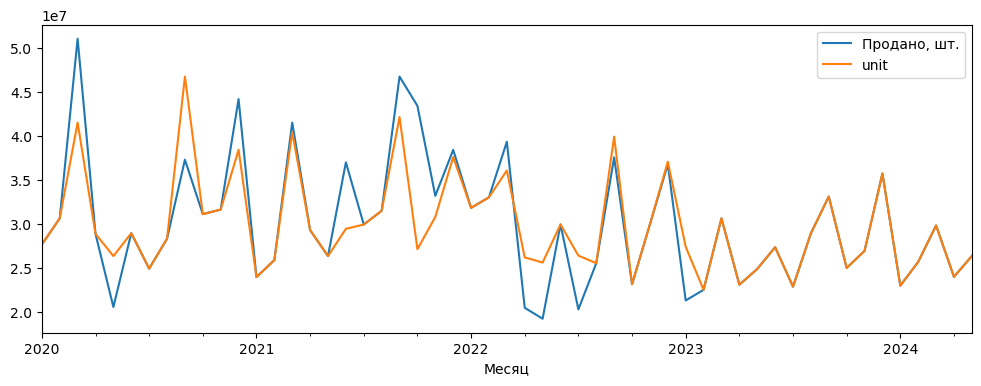

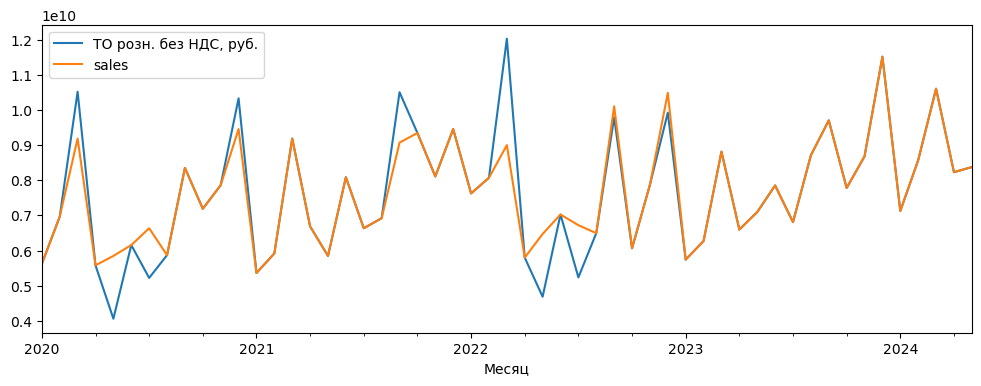

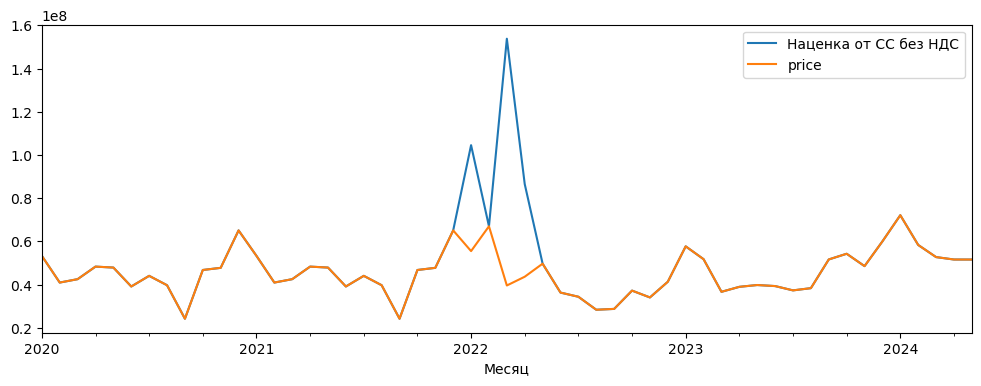

In [ ]:
# #визуализация очистки аномалий
df0 = df0.assign(unit = df_model.unit,
                 sales = df_model.sales,
                 price = df_model.price).set_index('Месяц')
df0 = df0[['Продано, шт.','ТО розн. без НДС, руб.','Наценка от СС без НДС','unit','sales','price']]

# # #изменение проданных штук
df0[['Продано, шт.','unit']].plot(figsize=(12, 4));

# # #изменение товарооборота
df0[['ТО розн. без НДС, руб.','sales']].plot(figsize=(12, 4));

# # #изменение наценок
df0[['Наценка от СС без НДС','price']].plot(figsize=(12, 4));

Сначала прогнозирую проданные единицы - они мне понадобятся для прогнозирования рублевой выручки, так как по матрице корреляции видим что коэфф = 0.71 и влияние на продажи значимое.

Подбираю параметры модели

In [ ]:
#прогнозируем штуки базовой моделью
df_model_unit = df_model[['ds','unit','dollar']]
df_model_unit.columns = ['ds','y','dollar']

#тест и трейн для основной модели прогноза ШТУК
df_train = df_model_unit[:-test_size]
df_test = df_model_unit[-test_size:]

#подбор параметров для прогноза ШТУК
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = N_trials)

[I 2024-07-08 10:03:39,701] A new study created in memory with name: no-name-b808c966-92d2-48db-b39c-6411cf47a377
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-07-08 10:03:40,333] Trial 0 finished with value: 4758683.976544847 and parameters: {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.7799999999999999, 'seasonality_prior_scale': 8, 'seasonality_mode': 'additive', 'yearly_seasonality': 15}. Best is trial 0 with value: 4758683.976544847.
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-07-08 10:03:40,597] Trial 1 finished with value: 2267613.633829807 and parameters: {'changepoint_prior_scale': 0.06, 'changepoint_range': 0.94, 'seasonality_prior_scale': 8, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 5}. Best is trial 1 with value: 2267613.633829807.
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40

Подаю в модель оптимальные параметры для прогнозирования штук, вывожу среднюю ошибку прогноза на трейне и на тесте

На трейне ошибка 6,9 %
На тесте 7,1 %

Модель стабильная, не переобученная.

In [ ]:
#Прогноз штук обученнной  базовой моделью
df_pred_unit = predict(df_model_unit, study.best_params)

#сообщение о средней ошибке на тесте и на трейне
df_test_unit_out = estimate_forecast(df_train, df_test, df_pred_unit).reset_index()

#выгрузка файла с прогнозом штук
df_test_unit_out['region'] = name
df_test_unit_out['business'] = business

df_test_unit_out = df_test_unit_out[['ds','region','business','y','lower','predictions','upper','delta','pct']]

#делаю копию прогноза на тест для последующей замены факта штук на прогноз штук
df_test_unit = df_test_unit_out.copy()

df_test_unit_out.columns = ['Месяц','Филиал','Бизнес','Штуки факт','Интервал_нижн','Штуки прогноз','Интервал_верхн','Ошибка','Ошибка %']
df_test_unit_out.to_csv(f'{name}UNIT.csv')

10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing


Средняя ошибка трейна: 0.06924780252859429
Средняя ошибка теста: 0.07172043175473368


Второй этап - прогнозирование товарооборота.
Подбираю параметры для моедели с допрегрессорами - штуками, наценкой, стоимостью доллара

In [ ]:
#Прогнозируем рубли c учетом  штук и наценки
df_model_sales = df_model[['ds','sales','unit','price','dollar']]
df_model_sales.columns = ['ds','y','unit','price','dollar']


#тест и трейн для модели прогноза РУБЛЕЙ
df_train = df_model_sales[:-test_size]
df_test = df_model_sales[-test_size:]

#подбор параметров для прогноза РУБЛЕЙ
study = optuna.create_study(direction='minimize')
study.optimize(objective_unit_price, n_trials = N_trials)


[I 2024-07-08 10:03:56,227] A new study created in memory with name: no-name-7d71552f-59d8-4b72-a613-f08f50decb16
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-07-08 10:03:56,610] Trial 0 finished with value: 1111320122.850153 and parameters: {'changepoint_prior_scale': 0.08, 'changepoint_range': 0.7799999999999999, 'seasonality_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13}. Best is trial 0 with value: 1111320122.850153.
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-07-08 10:03:56,824] Trial 1 finished with value: 519465901.9730615 and parameters: {'changepoint_prior_scale': 0.04, 'changepoint_range': 0.84, 'seasonality_prior_scale': 7, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 1}. Best is trial 1 with value: 519465901.9730615.
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10

Подаю рассчитанные оптимальные параметры в модель с допрегрессорами.

Ошибка на трейне 6,6%
Ошибка на тесте 5,1%

Модель стабильная, не переобученная

In [ ]:
#Прогноз рублей обученнной моделью
df_pred_sales = predict_unit_price(df_model_sales, study.best_params)

#сообщение о средней ошибке на тесте и на трейне РУБЛИ
df_test_sales_out = estimate_forecast(df_train, df_test, df_pred_sales).reset_index()

#выгрузка файла с прогнозом штук
df_test_sales_out['region'] = name
df_test_sales_out['business'] = business

df_test_sales_out = df_test_sales_out[['ds','region','business','y','lower','predictions','upper','delta','pct']]
df_test_sales_out.columns = ['Месяц','Филиал','Бизнес','Рубли факт','Интервал_нижн','Рубли прогноз','Интервал_верхн','Ошибка','Ошибка %']
df_test_sales_out.to_csv(f'{name}SALES.csv')

10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing


Средняя ошибка трейна: 0.06657404603362178
Средняя ошибка теста: 0.051988327955182385


ТОВАРООБОРТ
ШТУКИ


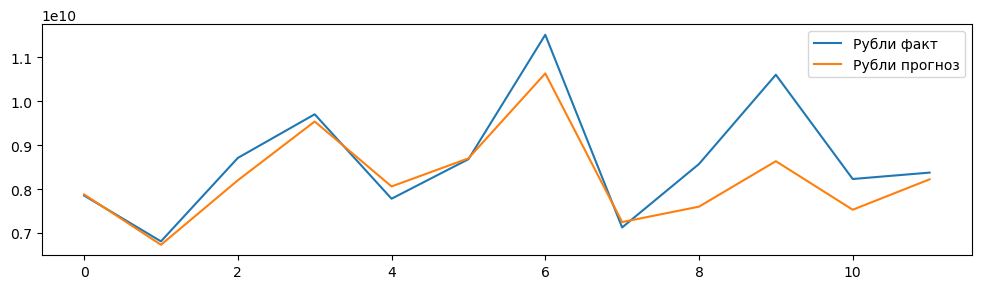

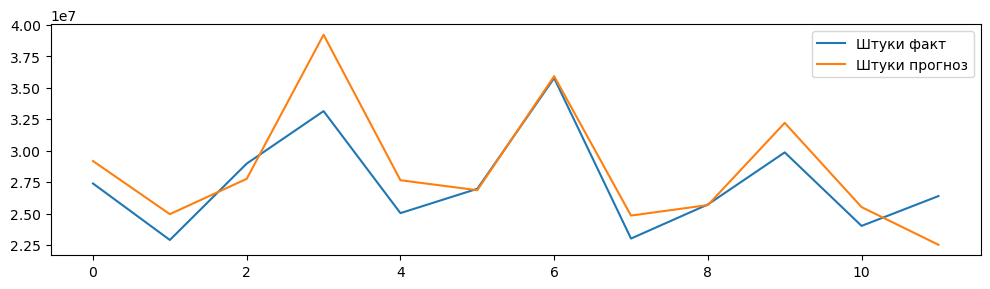

In [ ]:
#визуализация прогноза
print('ТОВАРООБОРТ')
df_test_sales_out[['Рубли факт','Рубли прогноз']].plot(figsize=(12, 3));

print('ШТУКИ')
df_test_unit_out[['Штуки факт','Штуки прогноз']].plot(figsize=(12, 3));

Итог - прогнозирование на 12 месяцев имеет среднюю ошибку 7% для прогноза проданных единиц и 5% для прогноза рублевой выручки.